# Data preparation

In [1]:
import pandas as pd

In [2]:
data_file = "D:\studia\PRO\inzynierka\dane.data"
data = pd.read_csv(data_file, sep='\t', header=0, low_memory=False)
data.head()

PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

In [3]:
phrases = data.iloc[0:, -2]
phrases.head()

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
Name: Phrase, dtype: object

In [4]:
labels = data.iloc[0:, -1]
labels.head()

0    1
1    2
2    2
3    2
4    2
Name: Sentiment, dtype: int64

##  Vectorization

### Tokenization

In [11]:
from nltk.corpus import stopwords
from string import punctuation
import re

def custom_tokenizer(phrase):
    clean_phrase = phrase.lower()
    clean_phrase = re.sub("[^a-z]", " ", clean_phrase)
    
    for _ in ['not', 'no']:
        pattern = "(^|\s+)" + _ + "\s+"
        clean_phrase = re.sub(pattern, " " + _, clean_phrase)
        
    for _ in ['don t', 'doesn t', 'won t', 'wouldn t', 'haven t', 'hasn t', 'couldn t', 'can t', 'must n']:
        pattern = "(^|\s)+" + _ + "\s+"
        clean_phrase = re.sub(pattern, " not", clean_phrase)
                                   
    clean_phrase = re.sub("(^|\s+)[a-z]\s+", " ", clean_phrase)   

    _stopwords = stopwords.words('english')
    return [word for word in clean_phrase.split() if not word in _stopwords]

In [12]:
custom_tokenizer("this film should not be missed ")

['film', 'notbe', 'missed']

### Term Frequency-Inverse Document Frequency

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, analyzer='word')

In [14]:
vectorized_phrases_tfid = tfidf_vectorizer.fit_transform(phrases)

### Simple count

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorize = CountVectorizer(tokenizer=custom_tokenizer, analyzer='word') 
vectorized_phrases_count = count_vectorize.fit_transform(phrases)

## Train-test split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_data_tfidf, test_data_tfidf, train_label, test_label = train_test_split(vectorized_phrases_tfid, labels, test_size=0.2, random_state=1)

In [18]:
train_data_count, test_data_count, train_label, test_label = train_test_split(vectorized_phrases_count, labels, test_size=0.2, random_state=1)

# Useful functions

In [19]:
from sklearn import metrics
from seaborn import heatmap
import matplotlib.pyplot as plt


def plot_heatmap(matrix, accuracy, labels, title):
    heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Accuracy: {:0.2f}%".format(accuracy * 100))
    plt.suptitle(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
def plot(predictions, title):
    label_set = set(test_label)
    matrix = metrics.confusion_matrix(test_label, predictions, labels=list(label_set))
    accuracy = metrics.accuracy_score(test_label, predictions)
    plot_heatmap(matrix, accuracy, label_set, title)

# Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB
classifier_tfidf = MultinomialNB()
classifier_count = MultinomialNB()

In [21]:
classifier_tfidf.fit(train_data_tfidf,train_label)

MultinomialNB()

In [22]:
classifier_count.fit(train_data_count,train_label)

MultinomialNB()

In [23]:
predictions_nb_tfidf = classifier_tfidf.predict(test_data_tfidf)

In [24]:
predictions_nb_count = classifier_tfidf.predict(test_data_count)

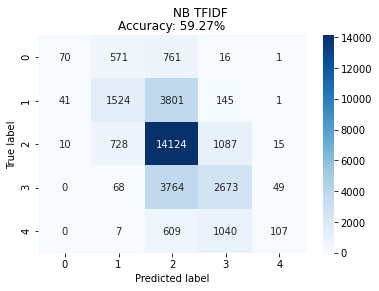

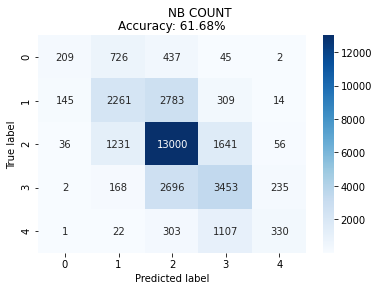

In [25]:
plot(predictions_nb_tfidf, "NB TFIDF")
plot(predictions_nb_count, "NB COUNT")

# Support Vector Machine

In [26]:
from sklearn.svm import LinearSVC
svc_classifier_tfidf = LinearSVC(max_iter=5000)
svc_classifier_count = LinearSVC(max_iter=5000)

In [27]:
svc_classifier_tfidf.fit(train_data_tfidf, train_label)

LinearSVC(max_iter=5000)

In [28]:
svc_classifier_count.fit(train_data_count, train_label)

LinearSVC(max_iter=5000)

In [29]:
predictions_svc_tfidf  = svc_classifier_tfidf.predict(test_data_tfidf)

In [30]:
predictions_svc_count  = svc_classifier_tfidf.predict(test_data_count)

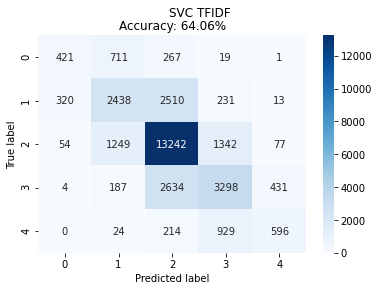

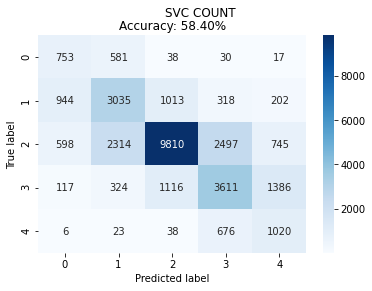

In [31]:
plot(predictions_svc_tfidf, "SVC TFIDF")
plot(predictions_svc_count, "SVC COUNT")


# Results

In [32]:
results = pd.DataFrame(phrases.iloc[test_label.index])

In [33]:
results['Tokenized'] = results["Phrase"].apply(custom_tokenizer)
results['Sentiment'] = test_label
results['NB TFIDF'] = predictions_nb_tfidf
results['SVM TFIDF'] = predictions_svc_tfidf
results['NB COUNT'] = predictions_nb_count
results['SVM COUNT'] = predictions_svc_count

In [34]:
results

Phrase  \
78734                                             Bad and   
126189  It 's a stale , overused cocktail using the sa...   
132845                                        of the gags   
126239                                        get to know   
30608   , High Crimes would be entertaining , but forg...   
...                                                   ...   
39751                                       film : honest   
105032                              Director Todd Solondz   
105833                          stringently takes to task   
54740   Wilde 's droll whimsy helps `` Being Earnest '...   
77706                which is all it seems intended to be   

                                                Tokenized  Sentiment  \
78734                                               [bad]          1   
126189  [stale, overused, cocktail, using, olives, sin...          0   
132845                                             [gags]          2   
126239                                        [get, know]          2   
30608    [high, crimes, would, entertaining, forgettable]          1   
...                                                   ...        ...   
39751                                      [film, honest]          3   
105032                          [director, todd, solondz]          2   
105833                         [stringently, takes, task]          2   
54740   [wilde, droll, whimsy, helps, earnest, overcom...          3   
77706                                   [seems, intended]          2   

        NB TFIDF  SVM TFIDF  NB COUNT  SVM COUNT  
78734          2          0         2          0  
126189         1          1         1          1  
132845         2          2         2          2  
126239         2          2         2          2  
30608          2          0         2          0  
...          ...        ...       ...        ...  
39751          3          3         3          3  
105032         2          2         2          2  
105833         2          2         2          2  
54740          3          3         3          3  
77706          2          2         2          2  

[31212 rows x 7 columns]

###  TFID

#### Correct NB prediction, incorrect SVM prediction

In [35]:
selected_rows = results.loc[(results['NB TFIDF'] == results['Sentiment']) &(results['SVM TFIDF'] != results['Sentiment'])]
selected_rows.iloc[0:, 0:5]

Phrase  \
42193   from musty memories of half-dimensional charac...   
1867                                             fantasia   
33120   All very stylish and beautifully photographed ...   
124729  It 's the type of stunt the Academy loves : a ...   
85142                                      a troubadour ,   
...                                                   ...   
114017  How I Killed My Father is one of those art hou...   
107029                                        best Korean   
59384                                          uncreative   
34420                                  and mainly unfunny   
134623  You 'll laugh at either the obviousness of it ...   

                                                Tokenized  Sentiment  \
42193    [musty, memories, half, dimensional, characters]          2   
1867                                           [fantasia]          2   
33120   [stylish, beautifully, photographed, far, trou...          3   
124729  [type, stunt, academy, loves, powerful, politi...          2   
85142                                        [troubadour]          2   
...                                                   ...        ...   
114017  [killed, father, one, art, house, films, makes...          2   
107029                                     [best, korean]          2   
59384                                        [uncreative]          1   
34420                                   [mainly, unfunny]          1   
134623  [laugh, either, obviousness, stupidity, maybe,...          2   

        NB TFIDF  SVM TFIDF  
42193          2          1  
1867           2          3  
33120          3          4  
124729         2          3  
85142          2          3  
...          ...        ...  
114017         2          0  
107029         2          4  
59384          1          0  
34420          1          2  
134623         2          3  

[2013 rows x 5 columns]

#### Correct SVM prediction, incorrect NB prediction

In [36]:
selected_rows = results.loc[(results['NB TFIDF'] != results['Sentiment']) &(results['SVM TFIDF'] == results['Sentiment'])]
selected_rows.iloc[0:, 0:5]

Phrase  \
53278   The movie attempts to mine laughs from a genre...   
66293   Amari has dressed up this little parable in a ...   
56311                                        equal laughs   
28843                                       are fantastic   
10954   your seat with its shape-shifting perils , pol...   
...                                                   ...   
21577                  distanced us from the characters .   
44835   be delighted simply to spend more time with fa...   
79867   plays as more of a poetic than a strict realit...   
114690  recommend waiting for DVD and just skipping st...   
138423                                    Just dreadful .   

                                                Tokenized  Sentiment  \
53278   [movie, attempts, mine, laughs, genre, gangste...          1   
66293   [amari, dressed, little, parable, fairly, irre...          4   
56311                                     [equal, laughs]          3   
28843                                         [fantastic]          4   
10954   [seat, shape, shifting, perils, political, int...          3   
...                                                   ...        ...   
21577                         [distanced, us, characters]          1   
44835   [delighted, simply, spend, time, familiar, car...          3   
79867   [plays, poetic, strict, reality, creating, int...          3   
114690  [recommend, waiting, dvd, skipping, straight, ...          1   
138423                                         [dreadful]          0   

        NB TFIDF  SVM TFIDF  
53278          2          1  
66293          3          4  
56311          2          3  
28843          3          4  
10954          2          3  
...          ...        ...  
21577          2          1  
44835          2          3  
79867          2          3  
114690         2          1  
138423         1          0  

[3510 rows x 5 columns]

#### Worst predictions

In [37]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
selected_rows = results.loc[((results['Sentiment'] == 4) & ((results['SVM TFIDF'] == 0) | (results['SVM TFIDF'] == 1) | (results['NB TFIDF'] == 0) | (results['NB TFIDF'] == 1))) | ((results['Sentiment'] == 0) & ((results['SVM TFIDF'] == 4) | (results['SVM TFIDF'] == 3) | (results['NB TFIDF'] == 4) | (results['NB TFIDF'] == 3)))]
selected_rows.iloc[0:, 0:5]

Phrase  \
101558                                                                                                                                      A deliciously nonsensical comedy about a city coming apart at its seams .   
153050                                                                                                                                 ... a good film that must have baffled the folks in the marketing department .   
153177                                                                                                It made me feel unclean , and I 'm the guy who liked There 's Something About Mary and both American Pie movies   
77895                                                                                                                                                                                                      stunningly   
95765                                                                                                                                                                            they wo n't enjoy the movie at all .   
40552                                                                                                                                                                           A thriller without a lot of thrills .   
64314                                                                                                                         that even the stuffiest cinema goers will laugh their \*\*\* off for an hour-and-a-half   
71413                                                                                                                                        when his story ends or just ca n't tear himself away from the characters   
95767                                                                                                                                                                                   wo n't enjoy the movie at all   
151438                                                                                                                                                             does n't have anything really interesting to say .   
130640                                                         The gags that fly at such a furiously funny pace that the only rip off that we were aware of was the one we felt when the movie ended so damned soon .   
86548                                                                                                                                                                                                      this loser   
28765                                                                                                                                                                                 remarkably dull with only Caine   
138076                                                                                                                                 By the standards of knucklehead swill , The Hot Chick is pretty damned funny .   
17847                                                                                                                                       achieves the remarkable feat of squandering a topnotch foursome of actors   
67637                                                                                                                        do n't think most of the people who loved the 1989 Paradiso will prefer this new version   
132442                                                                                                                                                   is a seriously intended movie that is not easily forgotten .   
88922                                                                                                                                                                                       a groundbreaking endeavor   
132441                                                                              

In [38]:
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 60)

### Count

#### Correct NB prediction, incorrect SVM prediction

In [39]:
selected_rows = results.loc[(results['NB COUNT'] == results['Sentiment']) &(results['SVM COUNT'] != results['Sentiment'])]
selected_rows.iloc[0:, [0,1,2,5,6]]

Phrase  \
53278   The movie attempts to mine laughs from a genre...   
27405                               consider a DVD rental   
87245   , Polanski is saying what he has long wanted t...   
86526       he represents Bartleby 's main overall flaw .   
125153  It would be churlish to begrudge anyone for re...   
...                                                   ...   
59384                                          uncreative   
88408                        the audience 's meat grinder   
34420                                  and mainly unfunny   
108064   look at the ins and outs of modern moviemaking .   
103273  A fascinating examination of the joyous , turb...   

                                                Tokenized  Sentiment  \
53278   [movie, attempts, mine, laughs, genre, gangste...          1   
27405                             [consider, dvd, rental]          2   
87245   [polanski, saying, long, wanted, say, confront...          2   
86526         [represents, bartleby, main, overall, flaw]          2   
125153  [would, churlish, begrudge, anyone, receiving,...          2   
...                                                   ...        ...   
59384                                        [uncreative]          1   
88408                           [audience, meat, grinder]          2   
34420                                   [mainly, unfunny]          1   
108064             [look, ins, outs, modern, moviemaking]          2   
103273  [fascinating, examination, joyous, turbulent, ...          3   

        NB COUNT  SVM COUNT  
53278          1          0  
27405          2          1  
87245          2          3  
86526          2          1  
125153         2          1  
...          ...        ...  
59384          1          0  
88408          2          1  
34420          1          0  
108064         2          3  
103273         3          4  

[4795 rows x 5 columns]

#### Correct SVM prediction, incorrect NB prediction

In [40]:
selected_rows = results.loc[(results['NB COUNT'] != results['Sentiment']) &(results['SVM COUNT'] == results['Sentiment'])]
selected_rows.iloc[0:, [0,1,2,5,6]]

Phrase  \
143656  a retread story , bad writing , and the same o...   
75943                                         eat popcorn   
44868                             wo n't see the next six   
66293   Amari has dressed up this little parable in a ...   
28843                                       are fantastic   
...                                                   ...   
100477                                      how pertinent   
21577                  distanced us from the characters .   
117775  Puts to rest any thought that the German film ...   
57393                            same sledgehammer appeal   
138423                                    Just dreadful .   

                                                Tokenized  Sentiment  \
143656     [retread, story, bad, writing, old, silliness]          0   
75943                                      [eat, popcorn]          3   
44868                                [wo, see, next, six]          1   
66293   [amari, dressed, little, parable, fairly, irre...          4   
28843                                         [fantastic]          4   
...                                                   ...        ...   
100477                                        [pertinent]          2   
21577                         [distanced, us, characters]          1   
117775  [puts, rest, thought, german, film, industry, ...          4   
57393                              [sledgehammer, appeal]          3   
138423                                         [dreadful]          0   

        NB COUNT  SVM COUNT  
143656         1          0  
75943          2          3  
44868          2          1  
66293          3          4  
28843          3          4  
...          ...        ...  
100477         3          2  
21577          2          1  
117775         3          4  
57393          2          3  
138423         1          0  

[3771 rows x 5 columns]

#### Worst predictions

In [41]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
selected_rows = results.loc[((results['Sentiment'] == 4) & ((results['SVM COUNT'] == 0) | (results['SVM COUNT'] == 1) | (results['NB COUNT'] == 0) | (results['NB COUNT'] == 1))) | ((results['Sentiment'] == 0) & ((results['SVM COUNT'] == 4) | (results['SVM COUNT'] == 3) | (results['NB COUNT'] == 4) | (results['NB COUNT'] == 3)))]
selected_rows.iloc[0:, [0,1,2,5,6]]

Phrase  \
154551                                                                                                                                                                                Staggeringly dreadful romance .   
101558                                                                                                                                      A deliciously nonsensical comedy about a city coming apart at its seams .   
35974                                                                                                                                                                                this film should not be missed .   
22218                                                                                                                                                                 's not a comedic moment in this romantic comedy   
58823                                                                                                                                                                                J.K. Rowling 's marvelous series   
78524                                                                                                                                                                       The film is all over the place , really .   
77895                                                                                                                                                                                                      stunningly   
95765                                                                                                                                                                            they wo n't enjoy the movie at all .   
40552                                                                                                                                                                           A thriller without a lot of thrills .   
64314                                                                                                                         that even the stuffiest cinema goers will laugh their \*\*\* off for an hour-and-a-half   
77946                                                                                                                              yet story , character and comedy bits are too ragged to ever fit smoothly together   
71413                                                                                                                                        when his story ends or just ca n't tear himself away from the characters   
132956                                                                                singing and finger snapping it might have held my attention , but as it stands I kept looking for the last exit from Brooklyn .   
95767                                                                                                                                                                                   wo n't enjoy the movie at all   
64552                                                                                                                                                                                  Bloody Sunday lacks in clarity   
151438                                                                                                                                                             does n't have anything really interesting to say .   
102218                                                                                                                found its audience , probably because it 's extremely hard to relate to any of the characters .   
53643                                                                                                                                          comedy that takes an astonishingly condescending attitude toward women   
60811                                                                               

## Results without the strength of sentiment

In [42]:
import numpy as np
ignore_strength = np.vectorize({0: 'negative', 1:'negative', 2:'neutral', 3:'positive', 4:'positive'}.get)

In [43]:
def plot_without_strength(predictions, title):
    labels = ['negative', 'neutral', 'positive']
    labels_without_strength = ignore_strength(test_label)
    predictions_without_strength = ignore_strength(predictions)
    matrix = metrics.confusion_matrix(labels_without_strength,predictions_without_strength, labels=labels)
    accuracy = metrics.accuracy_score(labels_without_strength,predictions_without_strength)
    plot_heatmap(matrix, accuracy, labels, title)
    

### Naive Bayes

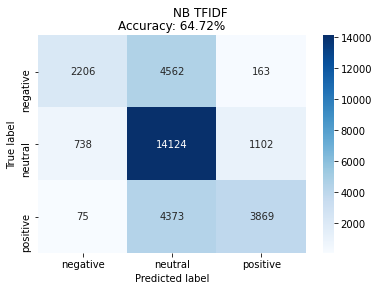

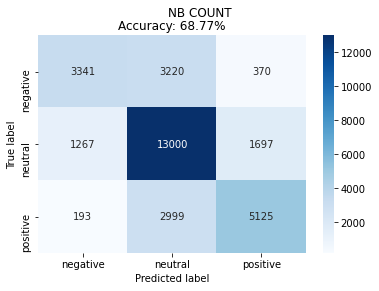

In [44]:
plot_without_strength(predictions_nb_tfidf, "NB TFIDF")
plot_without_strength(predictions_nb_count, "NB COUNT")

### Support Vector Machine

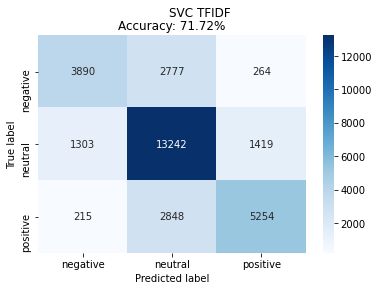

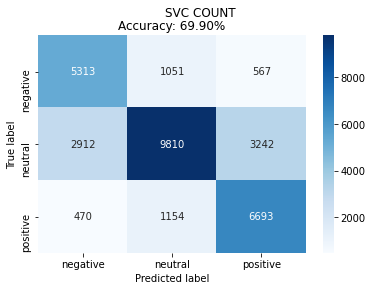

In [45]:
plot_without_strength(predictions_svc_tfidf, "SVC TFIDF")
plot_without_strength(predictions_svc_count, "SVC COUNT")